##  Notebook 2: Building a Logistic Regression Model, Comparing Its Pros/Cons To Random Forests, And Why Using Traditional Data Sceince Tools Is Insufficient For Assessing Expected Goals Models

Welcome to the 2nd notebook of my expected goals series! In this notebook, we will take a look at building a logistic regression model, with an emphasis on comparing strengths/weaknesses and paint points to a Random Forest. At the end, we will take a look at why the methodologies used in the first two notebooks are not sufficient to building a strong expected goals model, and preview what will come in the rest of the series.

For those that missed the 1st notebook, feel free to check it out  here: https://github.com/andrewsimplebet/expected_goals_deep_dive/blob/master/1.%20Random%20Forest%20Cross%20Validation%20And%20Hyperparameter%20Tuning.ipynb

This notebook will not go nearly as in depth on building a strong logistic regression as @CleKraus, who touches on a lot of really important concepts when it comes to building a logistic regression model for expected goals. I will  mention a couple of these concepts during our abbreviated selection, but the process that @CleKraus went through will help inform some of the comparisons with the Random Forest built in Notebook 1

@CleKraus' notebook: https://github.com/CleKraus/soccer_analytics/blob/master/notebooks/expected_goal_model_lr.ipynb

Let's start by loading in our data, and performing the same train/test split that we did in the Random Forest model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
shots_model = pd.read_csv('shots_design_matrix.csv')
shots_model = shots_model.drop(columns=['Unnamed: 0', 'firstName',  'lastName',  'label', 'venue', 'date', 'eventSec'])
y = shots_model['Goal']
x = shots_model.drop(['Goal'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Building a Logistic Regression Model For Expected Goals

For our initial Logistic Regression model, we will use the StatsModels implementation of Logistic Regression, as David does in his #FoT videos (https://www.youtube.com/channel/UCUBFJYcag8j2rm_9HkrrA7w/videos). We choose StatsModels initially because it provides nice outputs of p values associated with each feature, which aids in feature selection

Like we did for our Random Forest, let's fit a naive Logistic Regression model without playing with any parameters or features, to see how it performs:

In [3]:
initial_logistic_regression = sm.GLM(endog=y_train,exog=x_train,data=shots_model, 
                                           family=sm.families.Binomial()).fit()


Like like we did with the Random Forest, let's look at its train/test performance

In [4]:
train_y_hat = initial_logistic_regression.predict(x_train)
naive_train_log_loss = log_loss(y_train, train_y_hat)
naive_train_roc_auc = roc_auc_score(y_train, train_y_hat)
print('The log loss of our model on the training set is : ' +str(round(naive_train_log_loss, 4)))
print('The ROC AUC of our model on the training set is : ' +str(round(naive_train_roc_auc, 3)))

The log loss of our model on the training set is : 0.2776
The ROC AUC of our model on the training set is : 0.78


In [5]:
test_y_hat = initial_logistic_regression.predict(x_test)
naive_test_log_loss = log_loss(y_test, test_y_hat)
naive_test_roc_auc = roc_auc_score(y_test, test_y_hat)
print('The log loss of our model on the test set is : ' +str(round(naive_test_log_loss, 4)))
print('The ROC AUC of our model on the test set is : ' +str(round(naive_test_roc_auc, 3)))

The log loss of our model on the test set is : 0.2803
The ROC AUC of our model on the test set is : 0.783


In [6]:
train_fpr, train_tpr, train_thresholds = roc_curve(y_true=y_train, y_score=train_y_hat)
test_fpr, test_tpr, test_thresholds = roc_curve(y_true=y_test, y_score=test_y_hat)

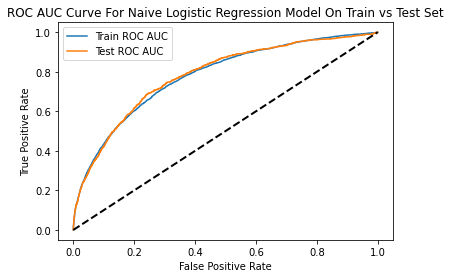

In [7]:
plt.plot(train_fpr, train_tpr, label = 'Train ROC AUC')
plt.plot(test_fpr, test_tpr, label = 'Test ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Naive Logistic Regression Model On Train vs Test Set')
plt.show()

This is awesome! We find that the training and testing metrics are not far off from one another, so we are not running the risk of overfitting to our training set. In addition, we find that the loss metrics out of sample are very close to the loss metrics produced by the Random Forest model in Notebook 1.

One of the advantages of logistic regression is that it's very easy to tell which features are important. To do this, we can simply look at the p values provided by the model However, we must be incredibly careful to consider the assumptions that underlie these p values

In [8]:
print(initial_logistic_regression.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Goal   No. Observations:                36227
Model:                            GLM   Df Residuals:                    36208
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10056.
Date:                Fri, 15 May 2020   Deviance:                       20111.
Time:                        00:05:59   Pearson chi2:                 6.48e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
X                   0.0421      0.024     

From this we can see that almost all of our variables are statistically significant. The 6 variables that aren't significant (at least by the naive p value test) are Y, side of field, C, prev_cross, prev_pass and prev_duel. These aren't quite the same as the Random Forest, but there's a bit of overlap. However, let's look a little deeper

One of the major assumptions of logistic regression is that the features are independent of each other. In this model,  that isn't quite the case. First, let's take a look at the pairwise correlations between variables

In [9]:
x_train.corr()

,X,Y,side_of_field,left_foot,right_foot,header,counter_attack,strong_foot,C,Distance,Angle,out_swinging,in_swinging,rebound,prev_cross,prev_touch,prev_pass,prev_smart_pass,free_kick,prev_duel
X,1.000000,-0.011128,0.002720,0.082732,0.186053,-0.365134,-0.022532,0.326818,0.145191,0.955058,-0.598556,0.047176,0.221877,-0.066814,-0.276912,0.007502,0.262184,-0.133532,0.230940,-0.110923
Y,-0.011128,1.000000,-0.829888,-0.052021,0.042695,0.008735,0.001244,0.021040,-0.078803,-0.032940,0.035022,0.153475,-0.162634,0.007240,0.008920,0.012291,0.009052,0.018729,-0.013601,-0.026491
side_of_field,0.002720,-0.829888,1.000000,0.063379,-0.057101,-0.003610,-0.000291,-0.029055,0.079933,0.020817,-0.032532,-0.182455,0.188335,-0.002913,-0.011845,-0.001313,-0.008746,-0.017253,0.003323,0.021750
left_foot,0.082732,-0.052021,0.063379,1.000000,-0.724346,-0.301214,0.028796,-0.155623,0.100151,0.106176,-0.129563,0.147327,0.072718,0.005759,-0.097221,0.025930,0.044312,0.008548,0.026241,-0.014214
right_foot,0.186053,0.042695,-0.057101,-0.724346,1.000000,-0.439234,0.030632,0.579028,0.099753,0.204274,-0.191884,0.140855,0.181318,0.003739,-0.119583,0.031395,0.130112,0.049154,0.045118,-0.121433
header,-0.365134,0.008735,-0.003610,-0.301214,-0.439234,1.000000,-0.079889,-0.598066,-0.268470,-0.420884,0.434222,-0.386791,-0.345535,-0.012676,0.292080,-0.077211,-0.237697,-0.079124,-0.096596,0.186475
counter_attack,-0.022532,0.001244,-0.000291,0.028796,0.030632,-0.079889,1.000000,0.044337,0.035497,-0.010305,-0.037990,0.061479,-0.003512,-0.011383,-0.037122,-0.035346,0.027146,0.065114,-0.053325,0.016189
strong_foot,0.326818,0.021040,-0.029055,-0.155623,0.579028,-0.598066,0.044337,1.000000,0.203863,0.364393,-0.325161,0.210303,0.228046,-0.006529,-0.193032,0.034126,0.196487,0.035226,0.152909,-0.178973
C,0.145191,-0.078803,0.079933,0.100151,0.099753,-0.268470,0.035497,0.203863,1.000000,0.409503,-0.560243,0.078115,0.118946,-0.033444,-0.180259,-0.019317,0.055930,0.032245,0.115369,0.021693
Distance,0.955058,-0.032940,0.020817,0.106176,0.204274,-0.420884,-0.010305,0.364393,0.409503,1.000000,-0.731449,0.076738,0.233001,-0.070579,-0.310263,0.001958,0.256073,-0.108133,0.249823,-0.098185


This table might be a bit big and unwieldy, but we can pick out some variables that are insanely correlated: ``X/C``, ``Y/side of field``, ``left_foot``/``right_foot``, ``Distance/Angle``, and ``in_swinging/out_swinging``, ``Angle/X``. 

This makes sense, as all of these variables are derived from one another. For example ``in_swinging/outswinging`` are linear combinations  of ``right_foot``, ``left_foot`` and ``side_of_field``, while ``header``, ``left_foot`` and ``right_foot`` are also linear combinations of one another. In addition, ``Distance`` is directly derived from ``X`` and ``Y``, ``C`` is directly derived from ``Y``, and ``Angle`` is also derived from some of these variables. Thus, we must be really  careful when determining what features to remove to remove collinearity.

**To be honest, I am not sure if my following steps are correct, so please take this with a grain  of salt. However, this process will help illustrate some important points when we compare the pros/cons of logistic regression  to Random Forest**

**If you have suggestions for a better process, please reach out to me on Twitter @andrew_puopolo or by email puopolo4@gmail.com**

Anyways, looking at the output from the previous logistic regression, we can safely remove Y, left_foot (due to being linearly dependent on right_foot and header). We leave C in due to the fact that it was originally dependent  on ``Y`` and ``side of field``.  We will also drop  ``side of field`` as the effect from that has been covered by the features  ``in_swinging`` and ``out_swinging``

In [10]:
second_x_train = x_train.drop(columns=['Y', 'side_of_field', 'left_foot','prev_touch', 'prev_pass'])
second_x_test = x_test.drop(columns=['Y', 'side_of_field', 'left_foot','prev_touch', 'prev_pass'])

In [11]:
second_logistic_regression= sm.GLM(endog=y_train,exog=second_x_train,data=shots_model, 
                                           family=sm.families.Binomial()).fit()
print(second_logistic_regression.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Goal   No. Observations:                36227
Model:                            GLM   Df Residuals:                    36212
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10058.
Date:                Fri, 15 May 2020   Deviance:                       20117.
Time:                        00:06:01   Pearson chi2:                 6.95e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
X                   0.0414      0.024     

In [12]:
y_hat = second_logistic_regression.predict(second_x_test)
print(log_loss(y_test, y_hat))
print(roc_auc_score(y_test, y_hat))

0.2801969161504281
0.7831233842883496


Well that was cool! We reduced the complexity of our model while generating similar performance on a held out dataset. Now, we find that all features (except C) are statistically significant.

Now, we must consider interactions between variables. One of the main components of generalied linear models is that the  features  are assumed  to be linear on the  scale of the link function (in the case of logistic regression, that's the logit  scale). For example, our current model assumes that as the ball gets further from the goal, the impact (on the logit scale) scales in the same way. That's not a realistic assumption, so we need to hand craft some features in order to account for these interactions between various variables.

In addition, since Logistic Regression is often favored for being interpretable (more on that later), we will focus on constructing features that make sense for interpretataion, and attempt to isolate and quantify the effects of features

In the following cells, we will construct some interaction variables for our models:

In [13]:
third_x_train = second_x_train.drop(columns=['C', 'X'])
third_x_test = second_x_test.drop(columns=['C', 'X'])

In [14]:
third_x_train['header_distance'] = third_x_train['header']*third_x_train['Distance']
third_x_train['strong_distance'] = third_x_train['strong_foot']*third_x_train['Distance']
third_x_train['header_angle'] = third_x_train['header']*third_x_train['Angle']
third_x_train['strong_angle'] = third_x_train['strong_foot']*third_x_train['Angle']
third_x_train['in_swinging_angle'] = third_x_train['in_swinging']*third_x_train['Angle']
third_x_train['out_swinging_angle'] = third_x_train['out_swinging']*third_x_train['Angle']
third_x_train['free_kick_angle'] = third_x_train['free_kick']*third_x_train['Angle']
third_x_train['distance_angle'] = third_x_train['Distance']*third_x_train['Angle']
third_x_train['duel_header'] = third_x_train['prev_duel']*third_x_train['header']
third_x_train['distance_squared'] = third_x_train['Distance']*third_x_train['Distance']
third_x_train['strong_distance_squared'] = third_x_train['distance_squared']*third_x_train['strong_foot']

In [15]:
third_x_test['header_distance'] = third_x_test['header']*third_x_test['Distance']
third_x_test['strong_distance'] = third_x_test['strong_foot']*third_x_test['Distance']
third_x_test['header_angle'] = third_x_test['header']*third_x_test['Angle']
third_x_test['strong_angle'] = third_x_test['strong_foot']*third_x_test['Angle']
third_x_test['in_swinging_angle'] = third_x_test['in_swinging']*third_x_test['Angle']
third_x_test['out_swinging_angle'] = third_x_test['out_swinging']*third_x_test['Angle']
third_x_test['free_kick_angle'] = third_x_test['free_kick']*third_x_test['Angle']
third_x_test['distance_angle'] = third_x_test['Distance']*third_x_test['Angle']
third_x_test['duel_header'] = third_x_test['prev_duel']*third_x_test['header']
third_x_test['distance_squared'] = third_x_test['Distance']*third_x_test['Distance']
third_x_test['strong_distance_squared'] = third_x_test['distance_squared']*third_x_test['strong_foot']

In [16]:
third_logistic_regression= sm.GLM(endog=y_train,exog=third_x_train,data=shots_model, 
                                  family=sm.families.Binomial()).fit()
print(third_logistic_regression.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Goal   No. Observations:                36227
Model:                            GLM   Df Residuals:                    36204
Model Family:                Binomial   Df Model:                           22
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9995.0
Date:                Fri, 15 May 2020   Deviance:                       19990.
Time:                        00:06:02   Pearson chi2:                 3.68e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
right_foot                

Well, we find that most of our variables are significant, but our prior of header distance didn't work,  so let's remove that from the  model

The models we remove here come after playing around quite a bit with our model and seeing how it performs out of sample. We decided to remove both in swinging andout swinging because the coefficients above were almost identical,  which likely meant there some multicollinearity  at play

Note: Other interactions were tried but found to be insignificant, so they were left out of this part of the analysis

In [17]:
fourth_x_train = third_x_train.drop(columns=['header_distance', 'rebound', 'in_swinging', 
                                             'out_swinging', 'in_swinging_angle',
                                             'out_swinging_angle', 'header_angle'])

fourth_x_test = third_x_test.drop(columns=['header_distance', 'rebound', 'in_swinging', 
                                           'out_swinging', 'in_swinging_angle', 
                                           'out_swinging_angle', 'header_angle'])

In [18]:
fourth_logistic_regression= sm.GLM(endog=y_train,exog=fourth_x_train,data=shots_model, 
                                           family=sm.families.Binomial()).fit()
print(fourth_logistic_regression.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Goal   No. Observations:                36227
Model:                            GLM   Df Residuals:                    36210
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9996.1
Date:                Fri, 15 May 2020   Deviance:                       19992.
Time:                        00:06:02   Pearson chi2:                 3.69e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
right_foot                

In [19]:
y_hat = fourth_logistic_regression.predict(fourth_x_test)
print(log_loss(y_test, y_hat))
print(roc_auc_score(y_test, y_hat))

0.2780954566668553
0.786953668742806


And that's it for our Logistic regression model!

Even if you read through all of this, I would still recommend reading @CleKraus' notebook on building a logistic regression, as that notebook is more complete and stresses different points of emphasis to this one, as well as doing a more thorough model evaluation process.

### Comparing  Logistic Regression  and Random Forest

Now that we've gone through the process of comparing our logistic regression and Random Forest, it's time to compare the two models against each other. We will use the lessons leaarned from the first 2 notebooks to help guide this section

#### Logistic Regression:

<b> Pros: </b> <br> <br>
1.) Super fast to run <br>
2.) Easy to mathematically quanatify the impact that each feature has on the model <br>
3.) Easier to identify which features matter <br>
4.) Less prone to overfitting, and generally requires less data  <br>
5.) Extrapolates well to data that  is outside the bounds of the training test

<b> Cons: </b> <br> <br>
1.) Assumes that features are linearly correlated (on the logit scale). <br>
2.) Lots of effort into feature engineering required. Must hand calculate features and sometimes unclear what the correct decision is. <br>
3.) Model coefficients can be uninterpretabale/misleading if multicollinearity present <br>
4.) Sensitive to outliers

#### Random Forest

<b> Pros: </b> <br> <br>
1.) Able to easily handle nonlinear interacations between variables, and better handles nonlinear decision surfaces <br>
2.) Often has superior predictive performance with a large sample size<br>
3.) Algorithm determines which features are important more easily  <br>
4.) Less human input required to generate features <br>
5.) Easier to handle categorical features <br>

<b> Cons: </b> <br> <br>
1.) Slow to tune optimal hyperparameters <br>
2.) More prone to overfitting <br>
3.) Due to decision tree nature, outliers in training set can lead to unintuitive decision surfaces (more on this in Notebook 4!).  <br>
4.) Much more difficult to interpret impact of features on model output as well as the overall result (more on this in future Notebooks!) <br>
5.) Does not extrapolate well to data that it outside the bounds of the training set


### Comparing Random Forest And Logistic Regression  Based on Previously Used Metrics

In [20]:
rf_model = RandomForestClassifier(n_estimators=500,
                                  min_samples_split= 300,
                                  min_samples_leaf= 1,
                                  max_features= 8,
                                  max_depth= 8,
                                  criterion= 'gini',
                                  n_jobs=-1).fit(x_train, y_train)

rf_y_hat=rf_model.predict_proba(x_test)

In [21]:
print("The log loss of the Random Forest model on the test set is: " \
      +str(round(log_loss(y_test, rf_y_hat[:,-1]), 4)))
print("The ROC-AUC of score the Random Forest Model on the test set is: " \
      + str(round(roc_auc_score(y_test, rf_y_hat[:,-1]), 4)))

The log loss of the Random Forest model on the test set is: 0.2781
The ROC-AUC of score the Random Forest Model on the test set is: 0.7867


Let's bring the code from the last logistic regression  down

In [22]:
logistic_y_hat = fourth_logistic_regression.predict(fourth_x_test)
print("The log loss of the Logistic Regression model on the test set is: " + \
      str(round(log_loss(y_test, logistic_y_hat), 4)))
print("The ROC-AUC of the Logistic Regression model on the test set is: " + \
      str(round(roc_auc_score(y_test, logistic_y_hat), 4)))

The log loss of the Logistic Regression model on the test set is: 0.2781
The ROC-AUC of the Logistic Regression model on the test set is: 0.787


These metrics are almost identical, with a slight edge to the Random Forest.

Let's also look at the ROC-AUC curves:

In [23]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_true=y_test, y_score=rf_y_hat[:,-1])
logreg_fpr, logreg_tpr, logreg_thresholds = roc_curve(y_true=y_test, y_score=logistic_y_hat)

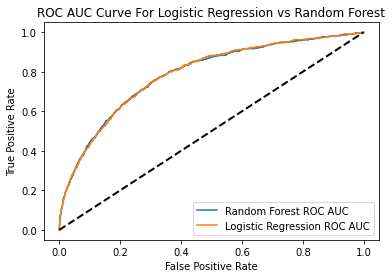

In [24]:
plt.plot(rf_fpr, rf_tpr, label='Random Forest ROC AUC')
plt.plot(logreg_fpr, logreg_tpr, label='Logistic Regression ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Logistic Regression vs Random Forest')
plt.show()

These curves are basically right on top of each other.

### Why Solely Using Data Science Loss Metrics To Evaluate/Choose A Model Is Insufficient and  Problematic

After looking at the above comparison between the two models, one could resaonably come to one of the following two conclusions for model selection:

#### Potential Takeaway 1: The Random Forest has better  log-loss  and ROC-AUC on a held out dataset, therefore we should pick the Random Forest

#### Potential Takeaway 2: The results are basically the same, so let's pick the Logistic Regresion because it's simpler and trains much  faster, and  the features are more interpretable

Let's think a bit more about  this:

In the April 9th weekly Friends of Tracking series video, Laurie Shaw asked Liverpool data scientist Will Spearman what it means to "improve a model" and Will replied <b>"I think the data scientist answer is your log loss goes down but I would almost never give that answer." "We don't care about log-loss, we care about calibration and we care about the football interpretability of your results"  </b>

Link to video: https://www.youtube.com/watch?v=kHTq9cwdkGA&t=2707s (clip at around 56 minutes)

Most machine learning models measure some sort of objective function, which is a mathematical output generated by the predictions and the true label. In the models we've fit so far, the objective function is the log-loss, and the model "learns" to optimize this quantity across all datapoints. The techniques we employed in the first two notebooks help us determine if the model is able to generalize to new data, and acheieve a satisfactory "score"  for this objective function on a held out data set.

Oftentimes optimizing an objective function is correlated but not directly related to what you hope to acheive with a model. Since we are optimizing an average quantity across a dataset, this could mean that the model is perfect in 99% of cases, but in 1% of cases is wildly off, which in theory could still optimize the global metric across all the datapoints.

As a data scientist in any industry, it is important to understand what the end goal of your work is (hint: unless it's Kaggle it's usually not optimizing log loss), and to develop tools and/or metrics to ensure successful delivery  and communication of key results

As a soccer data scientist, your end goal is often to communicate key findings efficiently and effectively to a coach or player. Therefore, you need to be confident that your findings are accurate before presenting them. As Will Spearman said in the video linked above, "you need to understand the ins and outs of your model, and understand where that model breaks down in  order to improve it."

Thus, you need to make sure that the specific output you are presenting is accurate/believable, otherwise you will lose credibility with the coach or player in the future.

To date, we have yet to build out anything that tests how accurate and understandable our models are. Therefore, we have no real way of knowing if the Random Forest or Logistic Regression is a better model for expected goals, despite employing quite a few sophisticated and well known data science techniques to build these models.

The purpose of the first 2 notebooks was to examine the strengths and weaknesses of these two model classes when trying to predict expected goals, which  will help  inform  us  when we test these models. In addition, the  notebooks help illustrate why traditional data science techniques are necessary but not sufficient to building an effective expected goals model.

In the rest of the series, we will focus on building tools to test and calibrate our models, and use these tools to find places where our model could be useful in presenting to a player or coach.